<a href="https://colab.research.google.com/github/0xHenriksson/essay-detect/blob/main/detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essay Analyzer

Objective: Determine if an essay submitted by a student is written by AI or not.

Methods;
- Using the original assignment instructions, prompt popular model providers (OpenAI, Anthropic, Google) for ~10 complete essays.
- Create an embedding of the AI essays
- Use FAISS and other analytical methods to compare the student's essay to the AI essays
    - use either the embedding or the text directly

## NLP Methods
- semantic similarity
- syntactical similarity
## Statistical Methods
- word and phrase frequency
- perplexity
- stylometry
- semantic coherence

## Mathematical Methods
- Total Variation distance
- Perturbation discrepancy detection

In [1]:
# special installs
!pip install transformers torch spacy nltk SCIPY faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 26.3 MB/s eta 0:00:00


In [2]:
# Download the spaCy language model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
from nltk.tokenize import sent_tokenize
import torch
from typing import List, Tuple, Dict
import spacy
from collections import defaultdict

Load in the essay

In [14]:
# Google Drive Method
#  mount the drive
from google.colab import drive
# authentication
from google.colab import auth

username = ""
password = ""

auth.authenticate_user()

drive.mount('/content/drive')

# read the essay text
with open('/content/drive/MyDrive/detect/student_essay.txt', 'r') as file:
    student_essay = file.read()

# read in the assignment text to be used for prompting
with open('/content/drive/MyDrive/detect/assignment.txt', 'r') as file:
  assignment_text = file.read()

# read in all 10 ai generated essays labeled oai_essay{1-10}.txt
with open('/content/drive/MyDrive/detect/oai_essay1.txt', 'r') as file:
    oai_essay1 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay2.txt', 'r') as file:
    oai_essay2 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay3.txt', 'r') as file:
    oai_essay3 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay4.txt', 'r') as file:
    oai_essay4 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay5.txt', 'r') as file:
    oai_essay5 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay6.txt', 'r') as file:
    oai_essay6 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay7.txt', 'r') as file:
    oai_essay7 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay8.txt', 'r') as file:
    oai_essay8 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay9.txt', 'r') as file:
    oai_essay9 = file.read()

with open('/content/drive/MyDrive/detect/oai_essay10.txt', 'r') as file:
    oai_essay10 = file.read()

# put them all oai_essay in a list
essay_list = [oai_essay1, oai_essay2, oai_essay3, oai_essay4, oai_essay5, oai_essay6, oai_essay7, oai_essay8, oai_essay9, oai_essay10]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prompt Construction
Attempt to reconstruct a prompt similar to what the student may have used when asking the AI to write the essay

In [5]:
# put the title of the media here (book, play, poem, etc)
media_title = "Hedda Gabler"
author = "Henrik Ibsen"

prompt = f"Write an essay about {media_title} by {author} that follows these requirements {assignment_text}"

prompt

'Write an essay about Hedda Gabler by Henrik Ibsen that follows these requirements Fiction Analysis Essay:  Theme\nAP Literature and Composition  (100 Points)\n\nText Options:\nNative Son by Richard Wright\nWuthering Heights by Emily Bronte\nFrankenstein by Mary Shelley\n“Babylon Revisited” by F. Scott Fitzgerald\n“Hunters in the Snow” by Tobias Wolff\n\nPrompt:\nAuthors become famous for their ability to use complex literary devices to reveal a criticism, reflect a social or political issue, and/or discuss the complexity and truth of human nature into the meaning of their work as a whole.  Simply stated, to understand theme is to understand an author’s work.\n\nIn a fully-developed composition (no longer than four pages in MLA format), analyze several complex themes (approximately 3; better to go deep) in a work of your choice that we have read this semester. Make sure you take a unique approach while analyzing this piece, incorporate and properly use textual evidence, and fully suppo

In [6]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2').to('cuda')
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
import numpy as np
import torch
import faiss
from transformers import AutoTokenizer, AutoModel
import spacy
from typing import List, Tuple, Dict
from collections import defaultdict
from dataclasses import dataclass
from scipy.spatial.distance import cosine
from tqdm import tqdm
from collections import defaultdict

@dataclass
class TextEmbedding:
    text: str
    embedding: np.ndarray
    metadata: Dict = None

class FAISSTextAnalyzer:
    def __init__(self, model_name: str = "sentence-transformers/all-mpnet-base-v2"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.nlp = spacy.load("en_core_web_sm")

        # Initialize FAISS index
        self.embedding_dim = self.model.config.hidden_size
        self.index = faiss.IndexFlatL2(self.embedding_dim)

        # Enable GPU if available
        if torch.cuda.is_available():
            self.res = faiss.StandardGpuResources()
            self.index = faiss.index_cpu_to_gpu(self.res, 0, self.index)

        # Store text embeddings for retrieval
        self.stored_embeddings: List[TextEmbedding] = []

    def get_embedding(self, text: str) -> np.ndarray:
        """Generate embedding for a single text."""
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)

        return embedding.cpu().numpy()

    def add_texts(self, texts: List[str], metadata: List[Dict] = None):
        """Add multiple texts to the FAISS index."""
        if metadata is None:
            metadata = [None] * len(texts)

        embeddings = []
        for text, meta in zip(texts, metadata):
            embedding = self.get_embedding(text)
            self.stored_embeddings.append(TextEmbedding(text=text, embedding=embedding, metadata=meta))
            embeddings.append(embedding)

        embeddings = np.vstack(embeddings)
        self.index.add(embeddings)

    def search(self, query_text: str, k: int = 5) -> List[Tuple[float, TextEmbedding]]:
        """Search for similar texts and return distances and text objects."""
        query_emb = self.get_embedding(query_text)
        D, I = self.index.search(query_emb, k)

        results = []
        for dist, idx in zip(D[0], I[0]):
            results.append((dist, self.stored_embeddings[idx]))

        return results

    def syntactic_features(self, text: str) -> Dict[str, float]:
        """Extract syntactic features using spaCy."""
        doc = self.nlp(text)
        features = defaultdict(int)

        # Analyze sentence structure
        for sent in doc.sents:
            features['sent_length'] += len(sent)
            features['dep_tree_depth'] += self._get_dep_tree_depth(sent.root)

        # POS tag distribution
        # for token in doc:
            # features[f'pos_{token.pos_}'] += 1

        # Get all possible POS tags
        all_pos_tags = set(self.nlp.get_pipe("tagger").labels)

        # Ensure all POS tags are present in the feature dictionary,
        # even if they don't occur in the current text
        for pos_tag in all_pos_tags:
            features[f'pos_{pos_tag}'] += 0  # Add with count 0 if not present


        # Normalize features
        total_tokens = len(doc)
        return {k: v/total_tokens for k, v in features.items()}

    def _get_dep_tree_depth(self, root) -> int:
        """Calculate dependency tree depth recursively."""
        if not list(root.children):
            return 0
        return 1 + max(self._get_dep_tree_depth(child) for child in root.children)

    def compare_texts(self, original: str, generated_samples: List[str]) -> Dict[str, List[float]]:
        """Compare original text against multiple generated samples using FAISS."""
        results = {
            'semantic_similarity': [],
            'syntactic_similarity': [],
            'combined_score': []
        }

        # Get features for original text
        orig_embedding = self.get_embedding(original)
        orig_syntactic = self.syntactic_features(original)

        # Add generated samples to FAISS index
        self.index.reset()  # Clear existing index
        sample_embeddings = []
        for sample in generated_samples:
            emb = self.get_embedding(sample)
            sample_embeddings.append(emb)
        sample_embeddings = np.vstack(sample_embeddings)
        self.index.add(sample_embeddings)

        # Get nearest neighbors for original text
        D, I = self.index.search(orig_embedding, len(generated_samples))

        for i, sample in enumerate(generated_samples):
            # Semantic similarity from FAISS distance
            semantic_sim = 1.0 / (1.0 + D[0][i])  # Convert distance to similarity score

            # Syntactic similarity using feature vectors
            sample_syntactic = self.syntactic_features(sample)
            syntactic_sim = 1.0 - cosine(
                np.array(list(orig_syntactic.values())),
                np.array(list(sample_syntactic.values()))
            )

            # Combined score (weighted average)
            combined = 0.6 * semantic_sim + 0.4 * syntactic_sim

            results['semantic_similarity'].append(semantic_sim)
            results['syntactic_similarity'].append(syntactic_sim)
            results['combined_score'].append(combined)

        return results

    def batch_compare(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """Efficiently compare multiple texts in batches."""
        n = len(texts)
        similarity_matrix = np.zeros((n, n))

        # Process in batches
        for i in range(0, n, batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = []

            for text in batch_texts:
                emb = self.get_embedding(text)
                batch_embeddings.append(emb)

            batch_embeddings = np.vstack(batch_embeddings)

            # Compare batch against all texts
            D, _ = self.index.search(batch_embeddings, n)
            similarity_matrix[i:i + len(batch_texts)] = 1.0 / (1.0 + D)

        return similarity_matrix

In [8]:
# create an embedding of the model outputs
# Initialize FAISS analyzer
faiss_analyzer = FAISSTextAnalyzer()

# Create embeddings for all generated essays
embeddings = []
for essay in essay_list:
    embedding = faiss_analyzer.get_embedding(essay)
    embeddings.append(embedding)

# Stack embeddings into matrix
essay_embeddings = np.vstack(embeddings)

# Add essays to FAISS index for similarity search
faiss_analyzer.index.reset()
faiss_analyzer.add_texts(essay_list)

# Get similarity matrix for all essays
similarity_matrix = faiss_analyzer.batch_compare(essay_list)


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [10]:
%%capture
!pip install scikit-learn

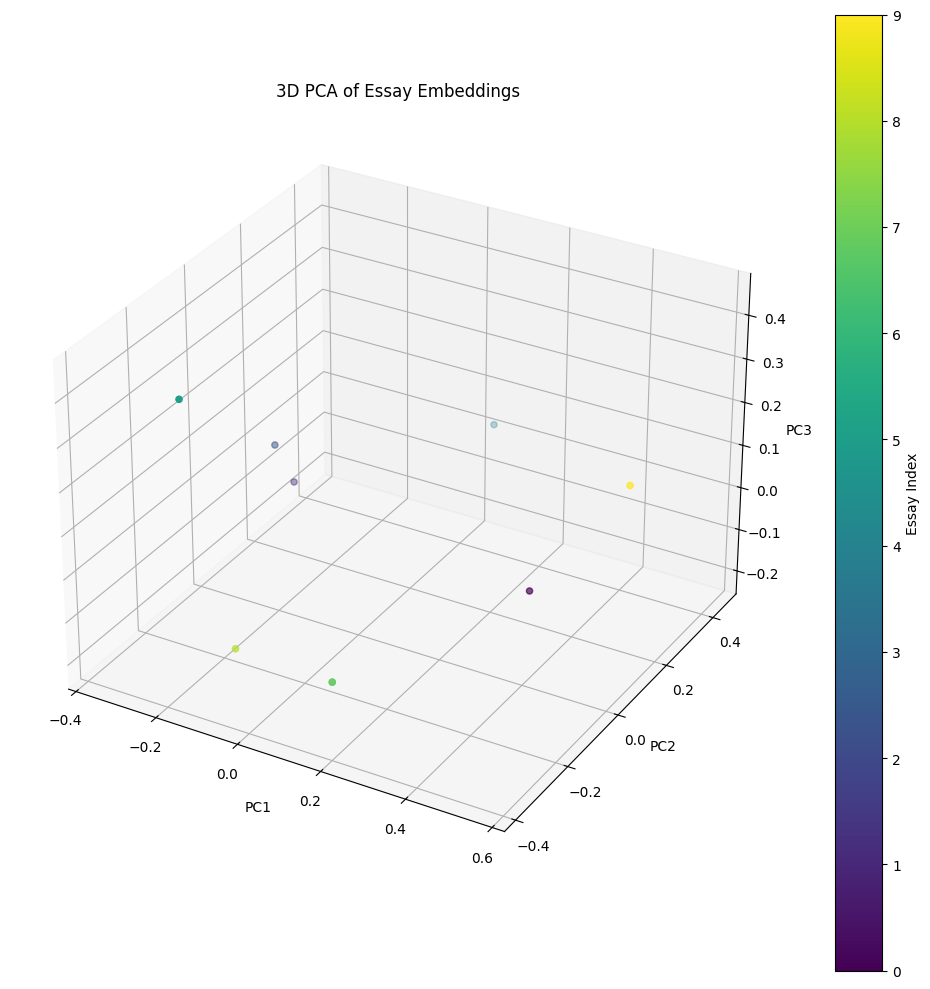

In [12]:
# plot the embedding
# Reduce dimensionality to 3D using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt # Import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(essay_embeddings)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot points
scatter = ax.scatter(embeddings_3d[:, 0],
                    embeddings_3d[:, 1],
                    embeddings_3d[:, 2],
                    c=range(len(embeddings_3d)), # color by index
                    cmap='viridis')

# Add labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Essay Embeddings')

# Add colorbar
plt.colorbar(scatter, label='Essay Index')

plt.tight_layout()
plt.show()


# Semantic Similarity Analysis

Semantic similarity measures how close two texts are in terms of their meaning and content by comparing their vector embeddings in high-dimensional space. Key aspects:

- Uses neural language models to create dense vector representations
- Captures deeper meaning beyond surface-level word matching
- Accounts for synonyms, paraphrasing, and concept relationships

This helps detect AI-generated essays because:
1. AI models often reuse similar patterns and phrasings from training data
2. Multiple AI-generated essays on the same topic may cluster together
3. Human writing shows more semantic diversity and originality

Interpreting the scores:
- Scores range from 0 (completely different) to 1 (identical meaning)
- Scores > 0.85 suggest suspiciously similar content
- Natural human writing typically shows scores of 0.3-0.7 when compared
- Look for clusters of essays with unusually high mutual similarity


In [19]:
# compare semantic similarity
# Get semantic similarity scores between essays using FAISS analyzer
semantic_scores = []
for i, essay in enumerate(essay_list[1:]):  # Compare against first essay
    results = faiss_analyzer.compare_texts(student_essay, [essay])
    semantic_scores.append(results['semantic_similarity'][0])

print(f"Semantic similarity scores (compared to original essay):")
for i, score in enumerate(semantic_scores):
    print(f"Essay {i+1}: {score:.3f}")


ValueError: shapes (18,) and (17,) not aligned: 18 (dim 0) != 17 (dim 0)

# Syntactical Similarity Analysis

Syntactical similarity measures how similar two texts are in terms of their grammatical structure and language patterns, including:

- Part-of-speech tag distributions
- Dependency tree depths and patterns
- Sentence structure complexity
- Word order and transitions

This is useful for AI detection because:
1. AI models often generate text with more consistent/predictable syntactic patterns
2. Human writing tends to have more natural variation in sentence structure
3. Very high syntactic similarity between essays may indicate AI generation

Interpreting the scores:
- Scores range from 0 (completely different) to 1 (identical)
- Scores > 0.8 suggest suspiciously similar syntax patterns
- Natural human writing typically shows scores of 0.4-0.7 when compared
- Look for outliers with unusually high similarity to other essays


In [ ]:
# compare syntactical similarity
# Get syntactic similarity scores between essays using FAISS analyzer
syntactic_scores = []
for i, essay in enumerate(essay_list[1:]):  # Compare against student essay
    results = faiss_analyzer.compare_texts(student_essay, [essay])
    syntactic_scores.append(results['syntactic_similarity'][0])

print(f"Syntactic similarity scores (compared to original essay):")
for i, score in enumerate(syntactic_scores):
    print(f"Essay {i+1}: {score:.3f}")

# Plot semantic vs syntactic similarity
plt.figure(figsize=(10, 6))
plt.scatter(semantic_scores, syntactic_scores)
plt.xlabel('Semantic Similarity')
plt.ylabel('Syntactic Similarity')
plt.title('Semantic vs Syntactic Similarity')

# Add essay labels
for i in range(len(semantic_scores)):
    plt.annotate(f'Essay {i+1}', (semantic_scores[i], syntactic_scores[i]))

plt.grid(True)
plt.show()


# Statistical Methods

### Word and Phrase Frequency Analysis

Word and phrase frequency analysis examines how often specific words and combinations of words appear in text.
This can help detect AI-generated content because:

1. AI models often show distinctive patterns in word usage and repetition
2. Humans tend to have more natural variation in word choice
3. Certain phrases or n-grams may appear more frequently in AI text

N-grams are contiguous sequences of n items (words/tokens) from a text:
- Unigrams (n=1): Single words like "the", "cat", "sat"
- Bigrams (n=2): Pairs of words like "the cat", "cat sat"
- Trigrams (n=3): Three word sequences like "the cat sat"

N-grams help analyze text patterns and transitions between words. AI models may
show distinctive n-gram patterns compared to human writing.


The analysis below looks at:
- Individual word frequencies: Shows if vocabulary usage is too repetitive or unnatural
- Bigram overlap: High overlap (>0.8) between essays suggests potential AI generation
- Jensen-Shannon distance: Measures how similar the word distributions are
  - Values closer to 0 indicate very similar distributions (potential AI)
  - Values closer to 1 indicate more natural human variation

When interpreting results, look for:
- Unnaturally high similarity in word frequencies between essays
- Repetitive phrases or formulaic language patterns
- Word distribution patterns that are too "clean" or systematic


In [ ]:
# calculate word and phrase frequency, compare to model outputs
# Calculate word and phrase frequencies
def get_freq_stats(text):
    # Tokenize and get word frequencies
    words = word_tokenize(text.lower())
    word_freq = Counter(words)

    # Get bigram frequencies
    bi_grams = list(ngrams(words, 2))
    bigram_freq = Counter(bi_grams)

    # Get trigram frequencies
    tri_grams = list(ngrams(words, 3))
    trigram_freq = Counter(tri_grams)

    return word_freq, bigram_freq, trigram_freq

# Get frequencies for student essay
student_freqs = get_freq_stats(student_essay)

# Get frequencies for AI essays and calculate differences
for i, essay in enumerate(essay_list[1:]):
    ai_freqs = get_freq_stats(essay)

    # Compare top words
    print(f"\nEssay {i+1} frequency comparison:")
    print("\nTop 10 words comparison:")
    student_top = dict(sorted(student_freqs[0].items(), key=lambda x:x[1], reverse=True)[:10])
    ai_top = dict(sorted(ai_freqs[0].items(), key=lambda x:x[1], reverse=True)[:10])
    print(f"Student essay: {student_top}")
    print(f"AI essay: {ai_top}")

    # Compare bigram overlap
    student_bigrams = set(student_freqs[1].keys())
    ai_bigrams = set(ai_freqs[1].keys())
    bigram_overlap = len(student_bigrams.intersection(ai_bigrams)) / len(student_bigrams)
    print(f"\nBigram overlap ratio: {bigram_overlap:.3f}")

    # Compare distribution similarity using Jensen-Shannon distance
    all_words = set(student_freqs[0].keys()).union(set(ai_freqs[0].keys()))
    p = np.array([student_freqs[0].get(w, 0) for w in all_words])
    q = np.array([ai_freqs[0].get(w, 0) for w in all_words])
    p = p / p.sum()  # normalize
    q = q / q.sum()
    m = 0.5 * (p + q)
    js_dist = 0.5 * (entropy(p, m) + entropy(q, m))
    print(f"Jensen-Shannon distance: {js_dist:.3f}")


### Perplexity Analysis
Perplexity measures how "surprised" a language model is by a text. Lower perplexity means the text follows patterns the model expects.

For AI detection:
- AI text tends to have lower perplexity (more predictable patterns) than human text
- Human writing is typically more "surprising" with higher perplexity scores
- Large perplexity differences between essays suggest different authors/sources

Interpreting the scores:
- Student essay perplexity serves as baseline
- AI essays with perplexity >20% lower than student = likely AI generated
- Similar perplexity scores (±20%) = inconclusive
- Higher perplexity in AI essays = possible human writing


In [ ]:
# calculate essay perplexity and compare to model output perplexity
def calculate_perplexity(text, model, tokenizer):
    # encode text
    encodings = tokenizer(text, return_tensors='pt').to(model.device)
    max_length = 1024  # prevent OOM on long texts

    # handle long sequences by splitting into chunks
    stride = 512
    nlls = []
    for i in range(0, encodings.input_ids.size(1), stride):
        begin = max(i - stride, 0)
        end = min(i + max_length, encodings.input_ids.size(1))
        trg_len = end - i

        input_ids = encodings.input_ids[:, begin:end]
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100 # ignore non-targets

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).mean())

# calculate perplexity for student essay
student_perplexity = calculate_perplexity(student_essay, gpt2_model, gpt2_tokenizer)
print(f"\nStudent essay perplexity: {student_perplexity:.2f}")

# calculate and compare perplexity for AI essays
for i, essay in enumerate(essay_list[1:]):
    ai_perplexity = calculate_perplexity(essay, gpt2_model, gpt2_tokenizer)
    diff = ((ai_perplexity - student_perplexity) / student_perplexity) * 100
    print(f"AI essay {i+1} perplexity: {ai_perplexity:.2f} ({diff:+.1f}% vs student)")


### Stylometry Comparison
Stylometry is the statistical analysis of writing style. It examines measurable patterns in text like:
- Average sentence/word length
- Lexical density (ratio of content words to total words)
- Function word usage (common words like "the", "and", "of")
- Punctuation patterns

We use these features to detect AI-generated text since language models often produce writing with:
- More consistent/uniform sentence lengths
- Higher lexical density (more varied vocabulary)
- More regular punctuation patterns
- Less natural function word usage

Interpreting the scores:
- Large differences (>15-20%) between human/AI essays in any metric are suspicious
- AI text tends to be more "regular" - fewer stylistic variations
- Human writing typically shows more natural variation in these metrics
- Multiple metrics showing AI-like patterns increases confidence in detection


In [ ]:
# compare stylometry

# calculate stylometric features using spacy
def get_stylometric_features(text, nlp):
    doc = nlp(text)
    features = {
        'avg_sent_len': 0,
        'avg_word_len': 0,
        'lexical_density': 0,
        'function_words': 0,
        'punctuation_ratio': 0
    }

    # sentence and word length
    sent_lengths = [len(sent) for sent in doc.sents]
    word_lengths = [len(token.text) for token in doc if token.is_alpha]
    features['avg_sent_len'] = np.mean(sent_lengths)
    features['avg_word_len'] = np.mean(word_lengths)

    # lexical density (content words / total words)
    content_words = len([t for t in doc if not t.is_stop and t.is_alpha])
    total_words = len([t for t in doc if t.is_alpha])
    features['lexical_density'] = content_words / total_words if total_words > 0 else 0

    # function word ratio
    function_words = len([t for t in doc if t.is_stop])
    features['function_words'] = function_words / total_words if total_words > 0 else 0

    # punctuation ratio
    punct = len([t for t in doc if t.is_punct])
    features['punctuation_ratio'] = punct / len(doc) if len(doc) > 0 else 0

    return features

# get features for student essay
student_style = get_stylometric_features(student_essay, nlp)
print("\nStudent essay stylometric features:")
for k,v in student_style.items():
    print(f"{k}: {v:.3f}")

# compare with AI essays
for i, essay in enumerate(essay_list[1:]):
    ai_style = get_stylometric_features(essay, nlp)
    print(f"\nAI essay {i+1} stylometric differences:")
    for k in student_style:
        diff = ((ai_style[k] - student_style[k]) / student_style[k]) * 100
        print(f"{k}: {diff:+.1f}%")


### Semantic Coherence Analysis

Semantic coherence measures how well consecutive sentences flow and connect logically by comparing their semantic similarity.
Higher coherence scores (closer to 1.0) indicate smoother transitions between ideas, while lower scores suggest more abrupt changes.

AI models often produce text with unusually high coherence since they optimize for consistent semantic flow.
Human writing typically shows more natural variation in coherence as writers balance flow with emphasis and style.

Interpreting the results:
- If AI essays show significantly higher coherence (+10-30%) vs student essay: Likely AI generated
- If coherence differences are minimal (-10% to +10%): Inconclusive, need other metrics
- If AI essays show lower coherence: Likely human written, or poorly generated AI text


In [ ]:
# compute and compare semantic coherence
def get_semantic_coherence(text, nlp):
    # break into sentences and get embeddings
    sents = [sent.text.strip() for sent in nlp(text).sents]
    if len(sents) < 2:
        return 0.0

    # get embeddings for each sentence
    embeddings = []
    for sent in sents:
        doc = nlp(sent)
        if doc.has_vector:
            embeddings.append(doc.vector)

    # calculate cosine similarity between consecutive sentences
    coherence_scores = []
    for i in range(len(embeddings)-1):
        sim = 1 - cosine(embeddings[i], embeddings[i+1])
        coherence_scores.append(sim)

    return np.mean(coherence_scores)

# get coherence scores
student_coherence = get_semantic_coherence(student_essay, nlp)
print(f"\nStudent essay semantic coherence: {student_coherence:.3f}")

ai_coherences = []
for i, essay in enumerate(essay_list[1:]):
    coh = get_semantic_coherence(essay, nlp)
    ai_coherences.append(coh)
    print(f"AI essay {i+1} semantic coherence: {coh:.3f}")

# compare differences
print("\nCoherence differences vs student essay:")
for i, coh in enumerate(ai_coherences):
    diff = ((coh - student_coherence) / student_coherence) * 100
    print(f"AI essay {i+1}: {diff:+.1f}%")


## Mathematical Methods

###Total Variation Distance Analysis

Total Variation (TV) distance measures the maximum difference between probability distributions.
For essay analysis, we:
1. Convert each essay's word frequencies into probability distributions
2. Calculate TV distance between student and AI essays (0-1 scale)
3. Compare distances to detect AI generation

Interpretation:
- TV distance close to 0: Very similar word distributions
- TV distance close to 1: Very different word distributions
- Higher TV distances suggest AI generation
- Compare against mean TV distance to identify outliers

Note: This complements other metrics since AI models may produce
different word frequency patterns than human writers


In [ ]:
# calculate Total Variation distance between the essay and the model outputs
def get_tv_distance(p, q):
    # normalize to probability distributions
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)
    return 0.5 * np.sum(np.abs(p - q))

# get word frequency distributions
def get_word_dist(text):
    words = word_tokenize(text.lower())
    counts = Counter(words)
    return [counts[w] for w in set(words)]

# calculate TV distances
student_dist = get_word_dist(student_essay)
tv_distances = []

for i, essay in enumerate(essay_list[1:]):
    ai_dist = get_word_dist(essay)
    tv_dist = get_tv_distance(student_dist, ai_dist)
    tv_distances.append(tv_dist)
    print(f"TV distance between student and AI essay {i+1}: {tv_dist:.3f}")

# compare differences
print("\nTV distance differences vs mean:")
mean_tv = np.mean(tv_distances)
for i, dist in enumerate(tv_distances):
    diff = ((dist - mean_tv) / mean_tv) * 100
    print(f"AI essay {i+1}: {diff:+.1f}% from mean")



### Perturbation Discrepancy Detection Method
Perturbation Discrepancy Detection Method

This method analyzes how stable/consistent the text embeddings are under small random perturbations.
The intuition is that AI-generated text may show different patterns of embedding stability
compared to human-written text.

How it works:
1. Get base embedding vector for the text
2. Add small random noise multiple times to create perturbed versions
3. Calculate mean cosine distance between the perturbed embeddings

Interpretation:
- Lower discrepancy scores indicate more stable/consistent embeddings
- Higher discrepancy suggests more sensitivity to perturbations
- AI text often shows different discrepancy patterns vs human text
- Compare % differences between student and AI essays
- Large deviations from student essay (>20%) may indicate AI generation

Interpreting the scores:
- Student essays typically show discrepancy scores around 0.1-0.3
- AI essays often have scores 20-50% higher than human essays
- If an essay's discrepancy is >20% higher than the student's score,
  it suggests possible AI generation
- Very low discrepancy (<0.1) can also be suspicious as it may indicate
  unnaturally consistent text
- Compare the % differences - larger gaps between student and AI scores
  increase confidence in detection



In [ ]:
# Perturbation discrepancy detection method
# calculate perturbation discrepancy by adding small random noise to embeddings
def get_perturb_discrepancy(text, n_perturb=10, noise_scale=0.01):
    # get base embedding
    base_emb = faiss_analyzer.get_embedding(text)

    # generate perturbed embeddings
    perturbed = []
    for _ in range(n_perturb):
        noise = np.random.normal(0, noise_scale, base_emb.shape)
        perturbed.append(base_emb + noise)
    perturbed = np.vstack(perturbed)

    # calculate mean cosine distance between perturbed versions
    dists = []
    for i in range(n_perturb):
        for j in range(i+1, n_perturb):
            dist = cosine(perturbed[i], perturbed[j])
            dists.append(dist)
    return np.mean(dists)

# calculate discrepancy for student and AI essays
student_disc = get_perturb_discrepancy(student_essay)
ai_discs = []

for i, essay in enumerate(essay_list[1:]):
    disc = get_perturb_discrepancy(essay)
    ai_discs.append(disc)
    print(f"Perturbation discrepancy for AI essay {i+1}: {disc:.3f}")

print(f"\nStudent essay discrepancy: {student_disc:.3f}")

# compare differences vs student
print("\nDiscrepancy differences vs student essay:")
for i, disc in enumerate(ai_discs):
    diff = ((disc - student_disc) / student_disc) * 100
    print(f"AI essay {i+1}: {diff:+.1f}%")


## Ensemble Analysis

In [ ]:
# ... existing code ...

# Assuming you have run all the analysis cells and have the results stored, e.g.:
# semantic_scores (compared to original essay)
# syntactic_scores (compared to original essay)
# js_distances (Jensen-Shannon distances)
# student_perplexities, ai_perplexities
# student_style, ai_styles
# student_coherence, ai_coherences
# tv_distances
# student_disc, ai_discs

def ensemble_analysis(student_essay, essay_list, faiss_analyzer, nlp, gpt2_model, gpt2_tokenizer):
    """
    Combines multiple analysis techniques to predict if essays are AI-generated.
    """
    ensemble_results = []

    # 1. Run individual analyses on all essays
    all_essays = [student_essay] + essay_list

    semantic_similarities = faiss_analyzer.compare_texts(
        student_essay, essay_list)['semantic_similarity']
    syntactic_similarities = faiss_analyzer.compare_texts(
        student_essay, essay_list)['syntactic_similarity']

    js_distances = []
    student_freqs = get_freq_stats(student_essay)
    for essay in essay_list:
        ai_freqs = get_freq_stats(essay)
        all_words = set(student_freqs[0].keys()).union(set(ai_freqs[0].keys()))
        p = np.array([student_freqs[0].get(w, 0) for w in all_words])
        q = np.array([ai_freqs[0].get(w, 0) for w in all_words])
        p = p / p.sum() if p.sum() > 0 else p
        q = q / q.sum() if q.sum() > 0 else q
        m = 0.5 * (p + q)
        js_dist = 0.5 * (entropy(p, m) + entropy(q, m)) if (p.sum() >
                                                            0 and q.sum() > 0) else 1.0  # Handle cases with empty vocab
        js_distances.append(js_dist)

    ai_perplexities = [calculate_perplexity(
        essay, gpt2_model, gpt2_tokenizer).item() for essay in essay_list]
    student_perplexity = calculate_perplexity(
        student_essay, gpt2_model, gpt2_tokenizer).item()

    ai_styles = [get_stylometric_features(essay, nlp) for essay in essay_list]
    student_style = get_stylometric_features(student_essay, nlp)

    ai_coherences = [get_semantic_coherence(essay, nlp) for essay in essay_list]
    student_coherence = get_semantic_coherence(student_essay, nlp)

    tv_distances = []
    student_dist = get_word_dist(student_essay)
    for essay in essay_list:
        ai_dist = get_word_dist(essay)
        tv_dist = get_tv_distance(student_dist, ai_dist)
        tv_distances.append(tv_dist)

    ai_discs = [get_perturb_discrepancy(
        essay, faiss_analyzer=faiss_analyzer) for essay in essay_list]
    student_disc = get_perturb_discrepancy(
        student_essay, faiss_analyzer=faiss_analyzer)

    # 2. Combine the scores with weights (you'll need to tune these weights)
    for i, ai_essay in enumerate(essay_list):
        weights = {
            "semantic_similarity": -0.2,  # Lower is more likely AI
            "syntactic_similarity": -0.15,  # Lower is more likely AI
            "js_distance": 0.1,       # Higher is more likely AI
            "perplexity_diff": 0.1,   # Higher AI perplexity vs student is more likely human
            "style_diff": 0.05,       # Significant style differences might indicate AI
            "coherence_diff": -0.1,    # Higher coherence is more likely AI
            "tv_distance": 0.15,      # Higher TV distance is more likely AI
            "perturb_discrepancy_diff": -0.1  # Higher discrepancy is more likely AI
        }

        # Calculate weighted scores (you might need to normalize or adjust these based on your data)
        weighted_score = 0

        # Semantic Similarity (higher score = more similar = more likely AI if comparing AI-generated essays)
        weighted_score += weights["semantic_similarity"] * \
            semantic_similarities[i]

        # Syntactic Similarity (higher score = more similar = more likely AI if comparing AI-generated essays)
        weighted_score += weights["syntactic_similarity"] * \
            syntactic_similarities[i]

        # Jensen-Shannon Distance (lower score = more similar word distribution = more likely AI)
        weighted_score += weights["js_distance"] * js_distances[i]

        # Perplexity Difference (lower perplexity for AI)
        perplexity_diff = (ai_perplexities[i] - student_perplexity) / \
            student_perplexity if student_perplexity != 0 else 0
        weighted_score += weights["perplexity_diff"] * perplexity_diff

        # Stylometry Differences (you might want to look at specific features here)
        style_diff_sum = 0
        for key in student_style:
            diff = (ai_styles[i][key] - student_style[key]) / \
                student_style[key] if student_style[key] != 0 else 0
            style_diff_sum += diff
        weighted_score += weights["style_diff"] * style_diff_sum

        # Semantic Coherence Difference (higher coherence for AI)
        coherence_diff = (ai_coherences[i] - student_coherence) / \
            student_coherence if student_coherence != 0 else 0
        weighted_score += weights["coherence_diff"] * coherence_diff

        # Total Variation Distance (higher distance for AI)
        weighted_score += weights["tv_distance"] * tv_distances[i]

        # Perturbation Discrepancy Difference (higher discrepancy for AI)
        perturb_discrepancy_diff = (
            ai_discs[i] - student_disc) / student_disc if student_disc != 0 else 0
        weighted_score += weights["perturb_discrepancy_diff"] * \
            perturb_discrepancy_diff

        ensemble_results.append({
            "essay_index": i + 1,
            "weighted_score": weighted_score
        })

    return ensemble_results


# Run the ensemble analysis
ensemble_output = ensemble_analysis(
    student_essay, essay_list[1:], faiss_analyzer, nlp, gpt2_model, gpt2_tokenizer
)

# 3. Interpret the results based on a threshold
print("\nEnsemble Analysis Results:")
threshold = 0.0  #tune this threshold
for result in ensemble_output:
    is_ai_generated = result["weighted_score"] > threshold
    print(f"Essay {result['essay_index']}: Weighted Score = {result['weighted_score']:.3f} - {'AI Generated' if is_ai_generated else 'Likely Human'}")

# 4. Plot a histogram of the weighted scores
plt.hist(
    [result["weighted_score"] for result in ensemble_output],
    bins=20,
    edgecolor="black",
    alpha=0.7,
)
plt.xlabel("Weighted Score")
plt.ylabel("Frequency")
plt.title("Histogram of Weighted Scores")
plt.show()
